In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/teach2_pkuhpc/gpfs1/xuzk/Anaconda/envs/py_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [3]:
raw_file = 'write_LCA/h_LCA1-5_raw.h5ad'
qc_file = 'write_LCA/h_LCA1-5_qc.h5ad'
filtered_file = 'write_LCA/h_LCA1-5_filtered.h5ad'
pp_file = 'write_LCA/h_LCA1-5_pp.h5ad'
results_file = 'write_LCA/h_LCA1-5.h5ad'  # the file that will store the analysis results

# marker genes

In [4]:
adata=sc.read_h5ad(results_file)
adata

AnnData object with n_obs × n_vars = 32686 × 4367
    obs: 'Barcode', 'Patient', 'Library', 'Most_likely_LM22_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Patient_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.uns['log1p']={'base': None}

In [5]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [25]:
adata.write(results_file)

# by singleR and metadata labels

In [7]:
#import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn as sns
def get_cluster_proportions(adata,
                            cluster_key="cluster_final",
                            sample_key="replicate",
                            drop_values=None):
    """
    Input
    =====
    adata : AnnData object
    cluster_key : key of `adata.obs` storing cluster info
    sample_key : key of `adata.obs` storing sample/replicate info
    drop_values : list/iterable of possible values of `sample_key` that you don't want
    
    Returns
    =======
    pd.DataFrame with samples as the index and clusters as the columns and 0-100 floats
    as values
    """
    
    adata_tmp = adata.copy()
    sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
    props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index() 
    props = props.pivot(columns=sample_key, index=cluster_key).T
    props.index = props.index.droplevel(0)
    props.fillna(0, inplace=True)
    
    if drop_values is not None:
        for drop_value in drop_values:
            props.drop(drop_value, axis=0, inplace=True)
    return props

def plot_cluster_proportions(cluster_props, 
                             cluster_palette=None,
                             xlabel_rotation=0): 
    fig, ax = plt.subplots(dpi=300)
    fig.patch.set_facecolor("white")
    
    cmap = None
    if cluster_palette is not None:
        cmap = sns.palettes.blend_palette(
            cluster_palette, 
            n_colors=len(cluster_palette), 
            as_cmap=True)
   
    cluster_props.plot(
        kind="bar", 
        stacked=True, 
        ax=ax, 
        legend=None, 
        colormap=cmap
    )
    
    ax.legend(bbox_to_anchor=(1.01, 1), frameon=False, title="Cluster")
    sns.despine(fig, ax)
    ax.tick_params(axis="x", rotation=xlabel_rotation)
    ax.set_xlabel(cluster_props.index.name.capitalize())
    ax.set_ylabel("Proportion")
    fig.tight_layout()
    
    return fig

In [22]:
adata.obs.groupby(['Major cell type','label_singleR']).size()['tNK cells']

label_singleR
Adipocytes             2
Astrocytes             0
B-cells               11
CD4+ T-cells          26
CD8+ T-cells         162
Chondrocytes           0
DC                     1
Endothelial cells      0
Eosinophils            0
Epithelial cells       0
Erythrocytes           0
Fibroblasts            0
HSC                   23
Keratinocytes          0
Macrophages            0
Melanocytes            0
Mesangial cells        0
Monocytes             20
Myocytes               0
NK cells             579
Neurons                0
Neutrophils            0
Pericytes              0
Skeletal muscle        0
Smooth muscle          0
null                   0
dtype: int64

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/tmp/ipykernel_9037/733297244.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


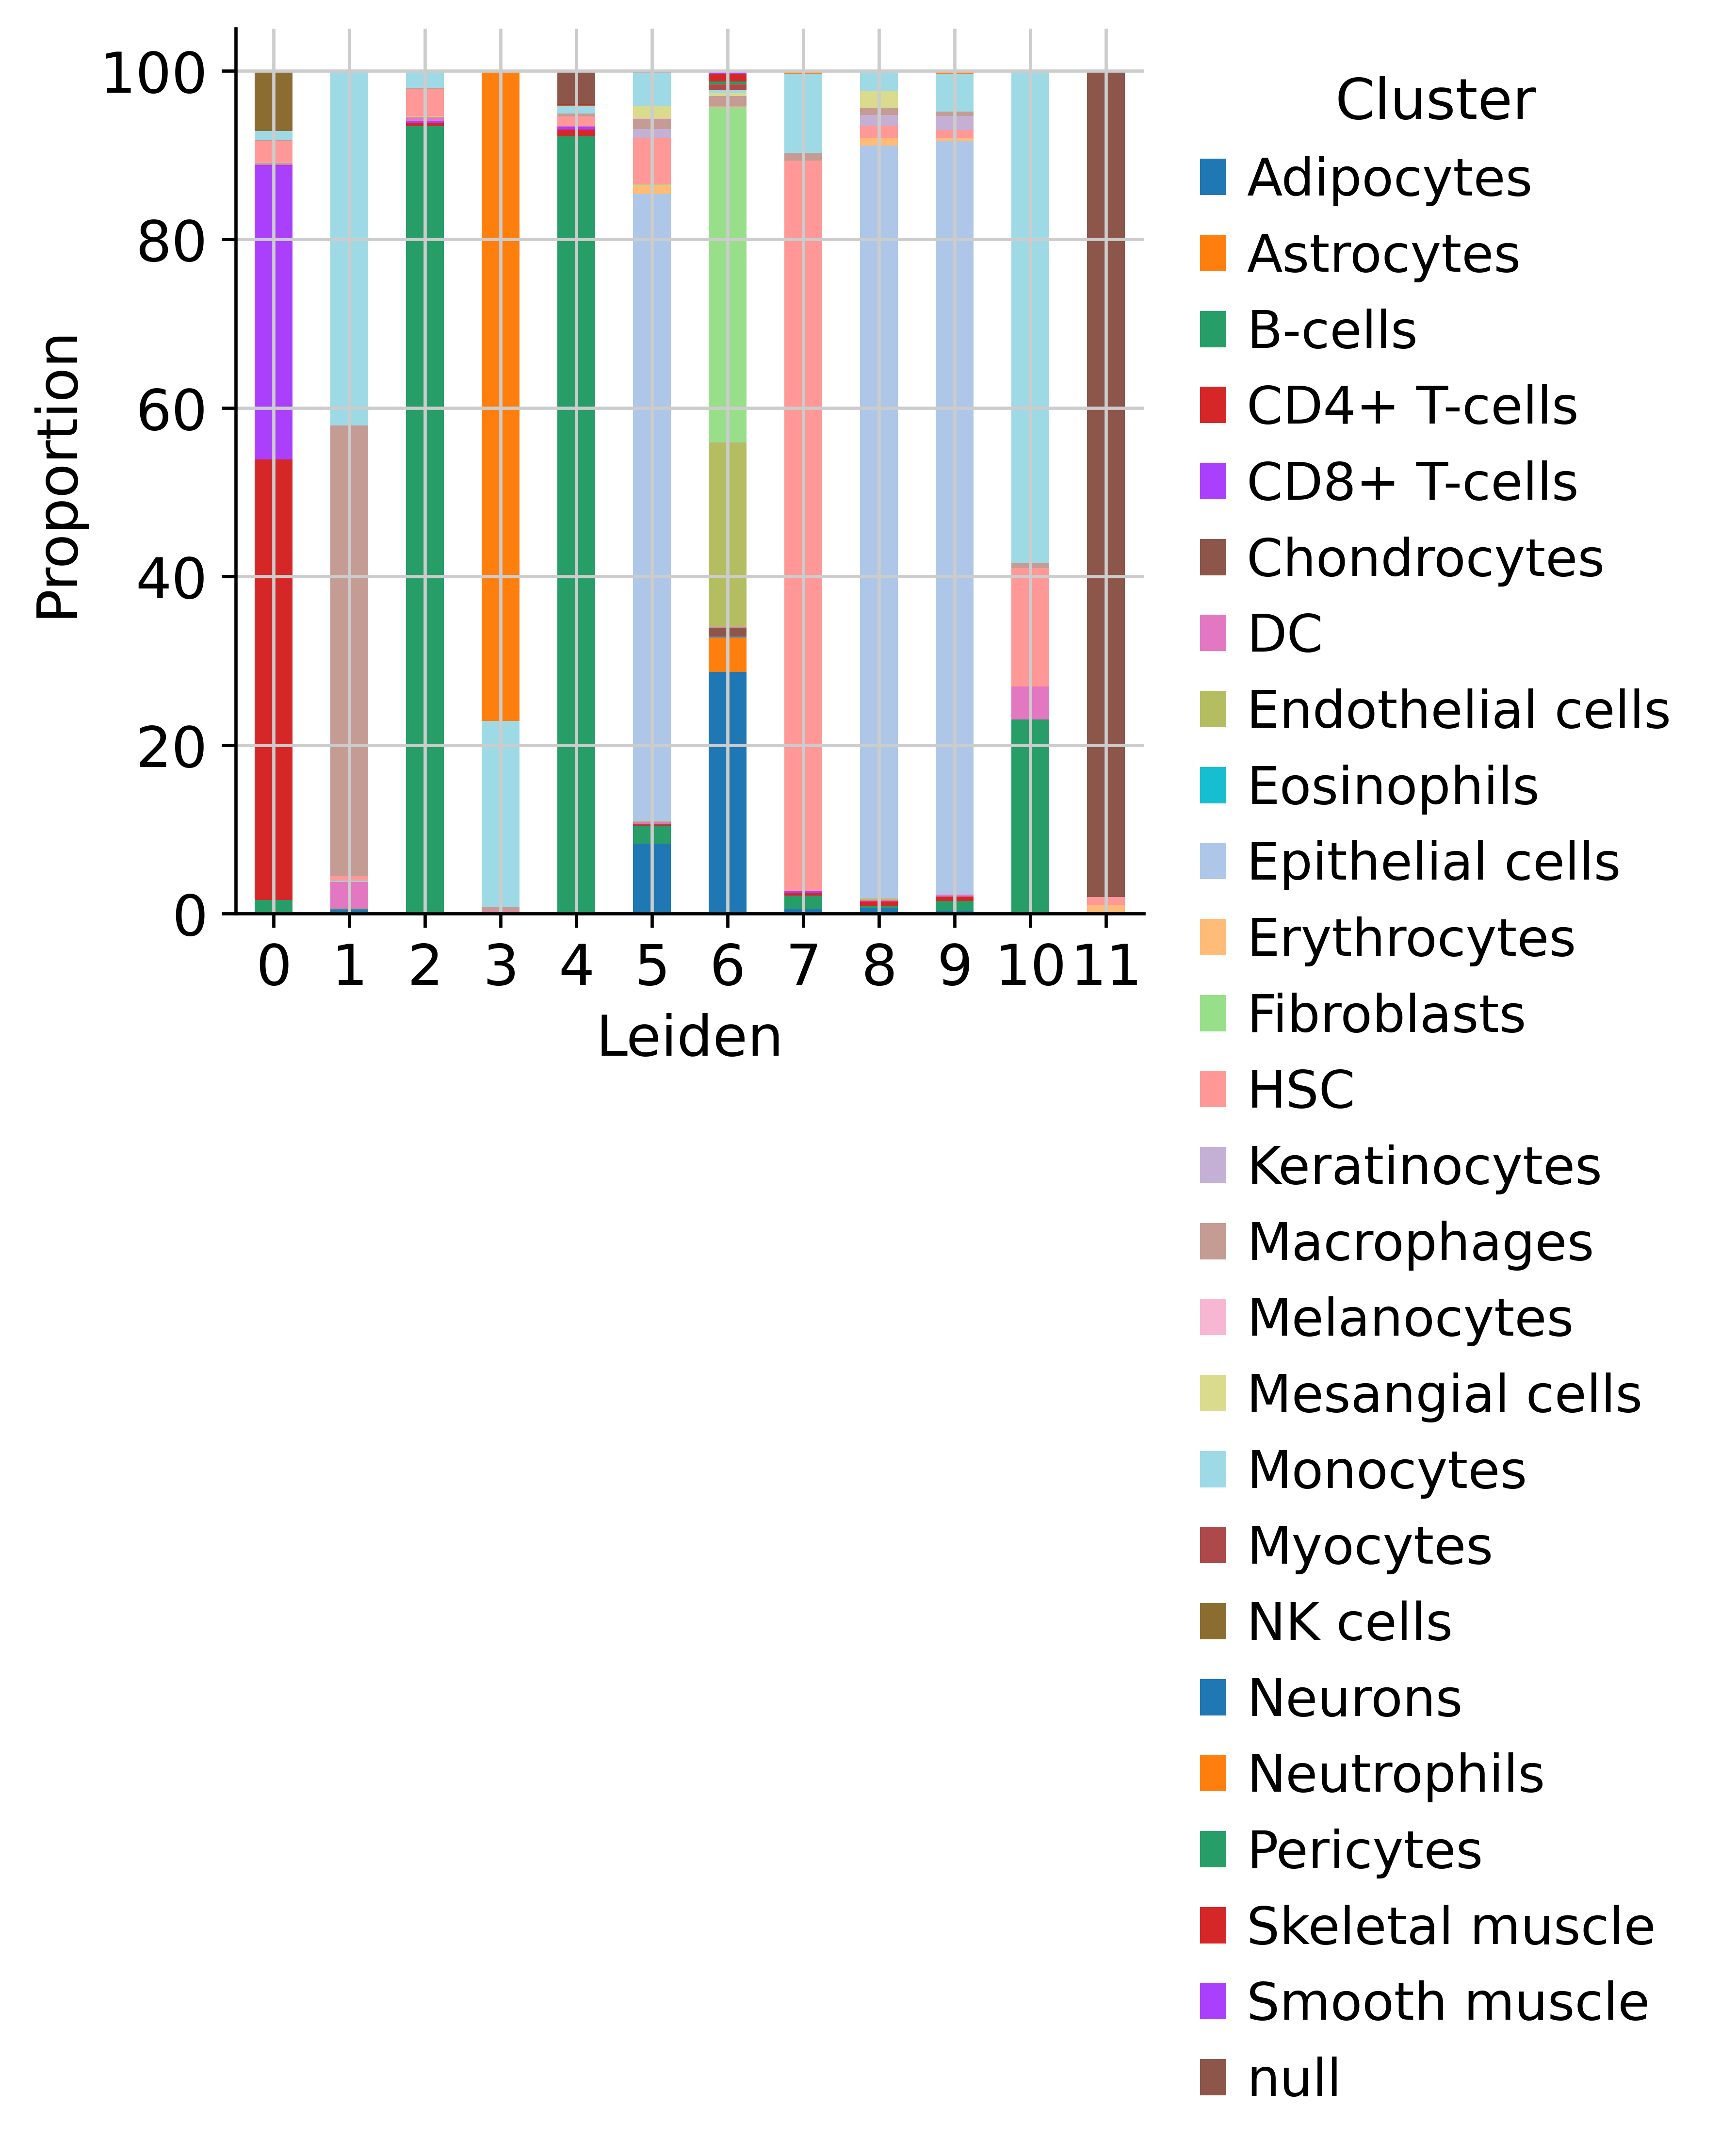

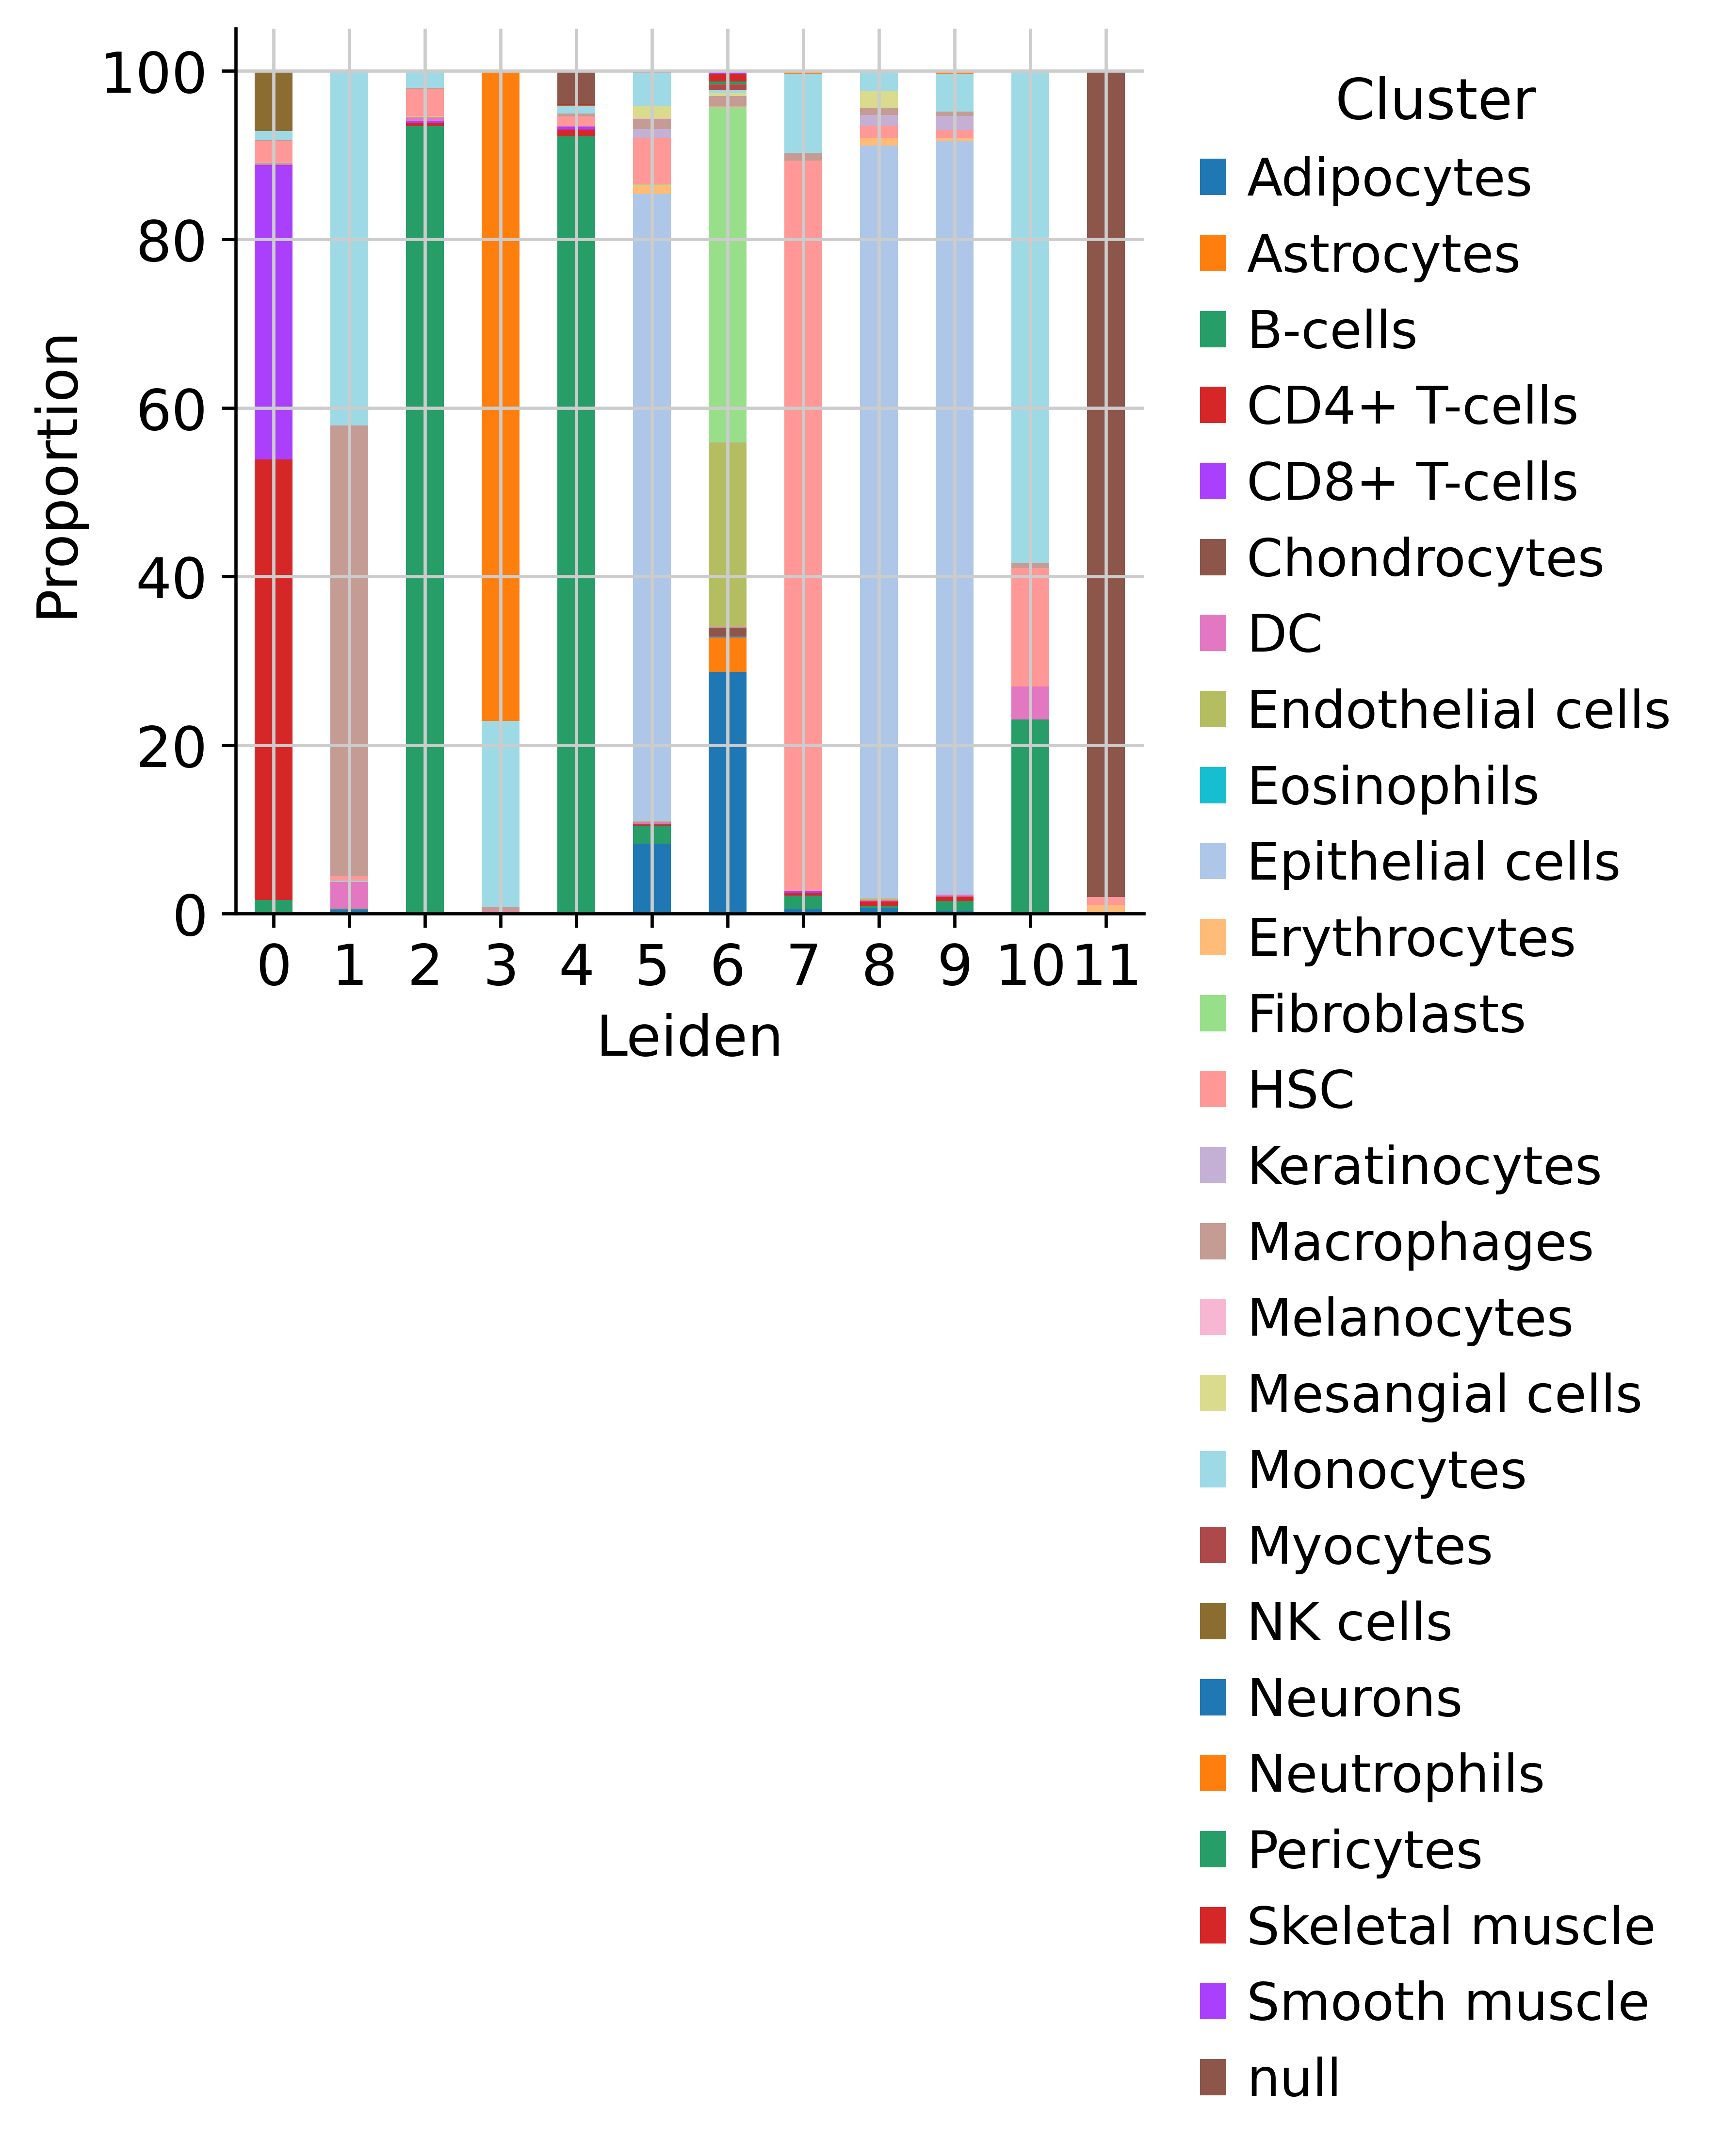

In [8]:
# leiden clusters - singleR annotation
cluster_props=get_cluster_proportions(adata, cluster_key='label_singleR',sample_key='leiden')
plot_cluster_proportions(cluster_props)

# Visualizing marker genes

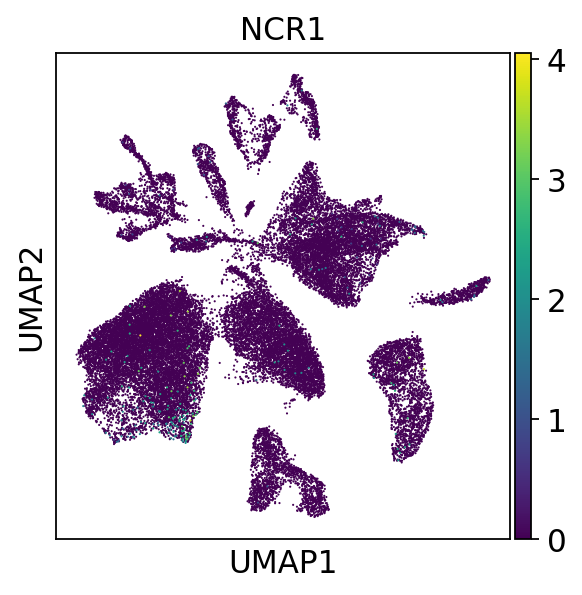

In [39]:
#sc.pl.umap(adata, color='NCR1', use_raw=False, vmin='p2')
sc.pl.umap(adata, color='NCR1')

# dissecting lymphoid cells

In [8]:
# create a dictionary to map cluster to lymphoid annotation label
cluster2annotation = {
     '0': 'y','1': 'n', '2': 'y','3': 'n', '4': 'y', '5': 'n', '6': 'n', '7': 'n', '8': 'n','10':'n','11':'n'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['lymphoid'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [9]:
adata[adata.obs.lymphoid=='y'].write('write_LCA/h_LCA1-5_lymphoid.h5ad')

In [10]:
adata=sc.read_h5ad('write_LCA/h_LCA1-5_lymphoid.h5ad')
adata

AnnData object with n_obs × n_vars = 18937 × 4367
    obs: 'Barcode', 'Patient', 'Library', 'Most_likely_LM22_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR', 'leiden', 'lymphoid'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Patient_colors', 'hvg', 'label_singleR_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
# create a dictionary to map cluster to lymphoid cell type rough annotation label
cluster2label = {
     '0': 'h-T/NK', '2': 'h-B','4': 'h-plasma'
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['label_rough'] = adata.obs['leiden'].map(cluster2label).astype('category')

In [12]:
adata.obs['label_rough']

p3t1-bcGUOS    h-plasma
p3t1-bcATNB         h-B
p3t1-bcCWKI         h-B
p3t1-bcETCL         h-B
p3t1-bcGIYH      h-T/NK
                 ...   
p7t2-bcFXSC      h-T/NK
p7t2-bcEJEP    h-plasma
p7t2-bcHFBA         h-B
p7t2-bcHAJY      h-T/NK
p7t2-bcCXBJ      h-T/NK
Name: label_rough, Length: 18937, dtype: category
Categories (3, object): ['h-T/NK', 'h-B', 'h-plasma']

In [13]:
adata.write('write_LCA/h_LCA1-5_lymphoid.h5ad')